In [4]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
from PYPERCH.pyperch.neural.backprop_nn import BackpropModule
from PYPERCH.pyperch.neural.rhc_nn import RHCModule
from PYPERCH.pyperch.neural.sa_nn import SAModule
from PYPERCH.pyperch.neural.ga_nn import GAModule
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler



ModuleNotFoundError: No module named 'pyperch'

In [6]:
diabetes = pd.read_csv('/workspaces/7641HW2/diabetes.csv')
diabetes['Outcome'] = diabetes['Outcome'].astype('category')
scaler = StandardScaler()
num_var =  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
diabetes[num_var] = scaler.fit_transform(diabetes[num_var])
cols = list(diabetes.columns)
cols.insert(0, cols.pop(cols.index('Outcome')))
diabetes = diabetes[cols]

In [7]:
def loading_data():
    X2 = np.array(diabetes.values[:,1:-1].astype(np.float32))
    y2 = np.array(diabetes.values[:,0].ravel().astype(np.int64))
    return X2,y2

In [8]:
cX,cY = loading_data()

In [10]:
def get_activation_fn(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'sigmoid':
        return nn.Sigmoid()
    elif name == 'tanh':
        return nn.Tanh()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

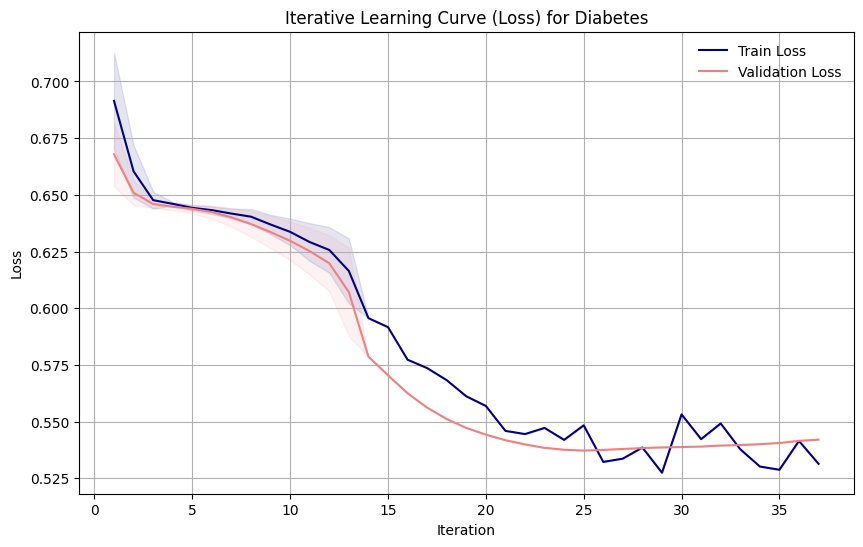

In [11]:
from skorch.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, make_scorer
from skorch.callbacks import EpochScoring,EarlyStopping
from sklearn.model_selection import cross_val_score, StratifiedKFold

activation_fn_name = 'sigmoid'
activation_fn = get_activation_fn(activation_fn_name)

# Define the neural net
net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=cX.shape[1],
    module__output_dim=2,
    module__hidden_units=10,
    module__hidden_layers=1,
    module__activation=activation_fn,
    module__dropout_percent=0.5,
    max_epochs=100,
    lr=0.01,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
        EarlyStopping(monitor='train_acc', patience=10, lower_is_better=False),
    ],
    verbose=0,
)

# Use StratifiedKFold for cross-validation to ensure class balance
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_losses = []
valid_losses = []

for train_index, valid_index in kf.split(cX, cY):
    X_train, X_valid = cX[train_index], cX[valid_index]
    y_train, y_valid = cY[train_index], cY[valid_index]
    
    net.fit(X_train, y_train)
    
    train_loss = np.array([epoch['train_loss'] for epoch in net.history])
    valid_loss = np.array([epoch['valid_loss'] for epoch in net.history])
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

max_len = max(len(tl) for tl in train_losses)
train_losses_padded = np.array([np.pad(tl, (0, max_len - len(tl)), 'constant', constant_values=np.nan) for tl in train_losses])
valid_losses_padded = np.array([np.pad(vl, (0, max_len - len(vl)), 'constant', constant_values=np.nan) for vl in valid_losses])

# Calculate mean and std for train and validation losses across folds
train_losses_mean = np.nanmean(train_losses_padded, axis=0)
train_losses_std = np.nanstd(train_losses_padded, axis=0)
valid_losses_mean = np.nanmean(valid_losses_padded, axis=0)
valid_losses_std = np.nanstd(valid_losses_padded, axis=0)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
iterations = range(1, len(train_losses_mean) + 1)
plt.fill_between(iterations, train_losses_mean - train_losses_std, train_losses_mean + train_losses_std, alpha=0.1, color='navy')
plt.fill_between(iterations, valid_losses_mean - valid_losses_std, valid_losses_mean + valid_losses_std, alpha=0.1, color='lightcoral')
plt.plot(iterations, train_losses_mean, label='Train Loss', color='navy')
plt.plot(iterations, valid_losses_mean, label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss) for Diabetes")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.savefig('LossCurveforNNDiabetes', dpi=300)
plt.show()

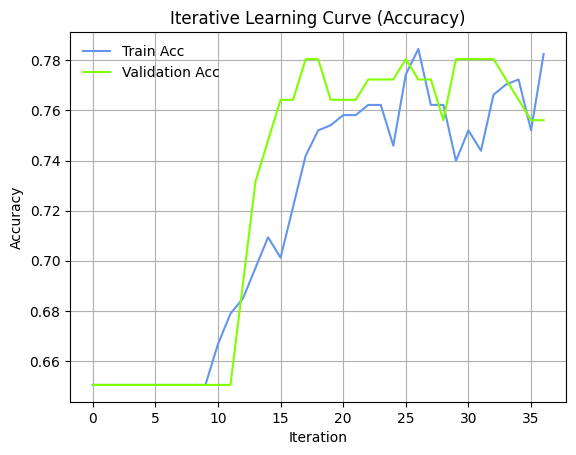

In [12]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

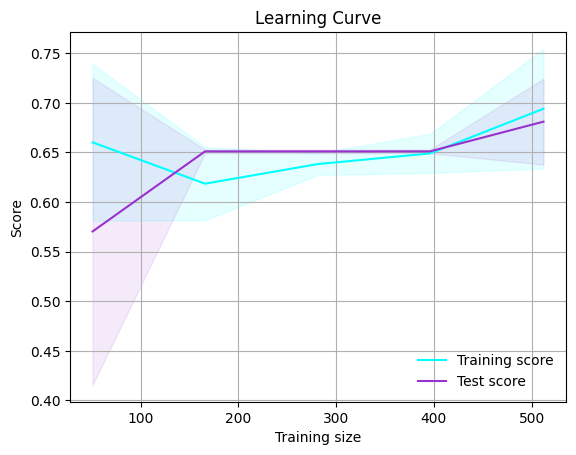

In [13]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, cX, cY, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(cX, cY)
y_proba = pipe.predict_proba(cX)

In [27]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

default_params = {
    'module__input_dim': [cX.shape[1]],
    'module__output_dim': [2],
}

# module specific parameters need to begin with 'module__'
params = {
    'lr': [0.01, 0.02,.1,.5],
    'max_epochs': [0,10, 20,30,40,50,60,70,80,90,100],
    'module__hidden_units': [50,100,200,300],
    'module__hidden_layers':[0,1,2,3],
    #'module__activation' : ['logistic','tanh','relu'],
    **default_params,
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(cX, cY)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 704 candidates, totalling 2112 fits
[CV] END lr=0.01, max_epochs=0, module__hidden_layers=0, module__hidden_units=50, module__input_dim=7, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=0, module__hidden_layers=0, module__hidden_units=50, module__input_dim=7, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=0, module__hidden_layers=0, module__hidden_units=50, module__input_dim=7, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=0, module__hidden_layers=0, module__hidden_units=100, module__input_dim=7, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=0, module__hidden_layers=0, module__hidden_units=100, module__input_dim=7, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=0, module__hidden_layers=0, module__hidden_units=100, module__input_dim=7, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=0, module__hidden_layers=0, module__hidd

[CV] END lr=0.01, max_epochs=10, module__hidden_layers=0, module__hidden_units=50, module__input_dim=7, module__output_dim=2; total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__hidden_layers=0, module__hidden_units=50, module__input_dim=7, module__output_dim=2; total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__hidden_layers=0, module__hidden_units=100, module__input_dim=7, module__output_dim=2; total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__hidden_layers=0, module__hidden_units=100, module__input_dim=7, module__output_dim=2; total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__hidden_layers=0, module__hidden_units=100, module__input_dim=7, module__output_dim=2; total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__hidden_layers=0, module__hidden_units=200, module__input_dim=7, module__output_dim=2; total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__hidden_layers=0, module__hidden_units=200, module__input_dim=7, module__output_dim=2;

In [1]:
#GD
#best score: 0.783, best params: {'lr': 0.02, 'max_epochs': 70, 'module__hidden_layers': 1, 'module__hidden_units': 50, 'module__input_dim': 7, 'module__output_dim': 2}